In [1]:
#3D Version
from mpi4py import MPI
import gmsh
from dolfinx.io import gmsh as gmshio
from dolfinx import mesh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))

comm = MPI.COMM_WORLD
rank = comm.rank

x_start, y_start = [0.25, 0.25], [0.25, 0.75]
x_end, y_end = [0.75, 0.5], [0.75, 0.5]

N_ref = 8


In [ ]:
#MESH GENERATION
for ref in range(N_ref+1):
    # --- user params ---
    h   = 1/(2**(ref+1))    # target size for Ω
    h_g = h/2   # target size for Γ

    gmsh.initialize()

    # ---------- Build Ω: structured quads via Gmsh ----------
    n_float = 1.0 / h
    n = int(round(n_float))
    if abs(n_float - n) > 1e-12:
        raise ValueError("For a regular Cartesian grid, choose h = 1/n (so 1/h must be an integer).")
    gmsh.model.add("Omega")

    # --- Base 2D geometry (z = 0 plane) ---
    p1 = gmsh.model.occ.addPoint(0, 0, 0)
    p2 = gmsh.model.occ.addPoint(1, 0, 0)
    p3 = gmsh.model.occ.addPoint(1, 1, 0)
    p4 = gmsh.model.occ.addPoint(0, 1, 0)

    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    cl = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([cl])
    gmsh.model.occ.synchronize()

    # --- Structured 2D mesh controls before extrusion ---
    gmsh.model.mesh.setTransfiniteCurve(l1, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l2, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l3, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l4, n + 1)
    gmsh.model.mesh.setTransfiniteSurface(surf)
    gmsh.model.mesh.setRecombine(2, surf)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

    # --- Extrude into a thin 3D slab ---
    out = gmsh.model.occ.extrude([(2, surf)], 0, 0, 0.02, numElements=[1], recombine=True)
    gmsh.model.occ.synchronize()

    # --- Define physical group for volume (dim=3) ---
    vols = [ent[1] for ent in gmsh.model.getEntities(dim=3)]
    pg_omega = gmsh.model.addPhysicalGroup(3, vols)
    gmsh.model.setPhysicalName(3, pg_omega, "Omega")

    # Optional: define boundary groups if needed
    # walls = [ent[1] for ent in gmsh.model.getEntities(dim=2)]
    # gmsh.model.addPhysicalGroup(2, walls)

    # --- Generate mesh ---
    gmsh.model.mesh.generate(3)
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.model_to_mesh(
        gmsh.model, comm, rank, gdim=3
    )[0:3]

    # --- Save Ω mesh before clearing ---
    if rank == 0:
        filename = f"Omega_ex1_{ref}.msh"
        gmsh.write(filename)

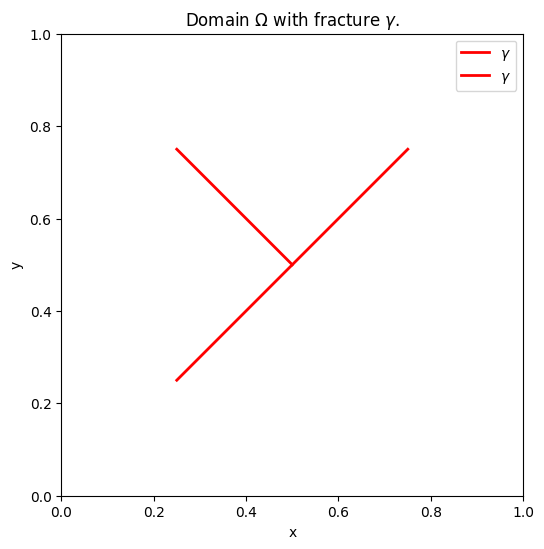

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot fracture γ
for i in range(len(x_start)):
        ax.plot([x_start[i], x_end[i]], [y_start[i], y_end[i]],
                'r-', linewidth=2, label=r"$\gamma$")

# Set exact domain bounds
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')  # force square axes

# Label and title
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"Domain $\Omega$ with fracture $\gamma$.")

# Disable autoscaling AFTER setting limits (prevents expansion)
ax.set_autoscale_on(False)

# Add legend last
ax.legend()

plt.show()

In [3]:
# APPROXIMATING EXACT SOLUTION
from dolfinx import mesh, fem
import ufl
import numpy as np
# from dolfinx.cpp.mesh import compute_cell_sizes

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
ref = N_ref
filename = f"Omega_ex1_{ref}.msh"
Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
# Compute cell diameters (length of the longest edge in each cell)
# all_h = compute_cell_sizes(Omega, "max")

# For example, get average or min/max
# h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

coords = Omega.geometry.x
hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
h = min(hx, hy)
# Clear gmsh model before building Γ
# gmsh.clear()

# ================= Γ: line (1D embedded in 3D plane z=0) =================
gmsh.initialize()
gmsh.model.add("Gamma")
h_g = h / 2

lines = []
for xs, ys, xe, ye in zip(x_start, y_start, x_end, y_end):
    p0 = gmsh.model.occ.addPoint(xs, ys, 0.01)
    p1 = gmsh.model.occ.addPoint(xe, ye, 0.01)
    lid = gmsh.model.occ.addLine(p0, p1)
    lines.append(lid)
    gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)

gmsh.model.occ.synchronize()

pg_gamma = gmsh.model.addPhysicalGroup(1, lines)
gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
gmsh.model.mesh.generate(1)

Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(
    gmsh.model, comm, rank, gdim=3)[0:3]

gmsh.finalize()

order = 1
V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
p_m, p_f, lmbd = ufl.TrialFunctions(W)

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(Omega)
f_m = fem.Constant(Omega, 0.0)
f_f = fem.Constant(Gamma, 0.0)

# k_m = fem.Constant(Omega, 1.0)
# Diagonal entries
k_values = np.array([[1.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])

# Define as a constant tensor field over Omega
k_m = fem.Constant(Omega, k_values)
k_f = fem.Constant(Gamma, 1.0)

dx = ufl.Measure("dx", domain=Omega)
ds = ufl.Measure("dx", domain=Gamma)

# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------
# --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
from fenicsx_ii import Average, Circle
import basix.ufl
R = np.min([0.01, h/4])        # tube/circle radius around Γ (tune as you like)
q_degree = 16   # quadrature degree along the circle (tune)

# Restriction operators for trial and test sides
restriction_trial = Circle(Gamma, R, degree=q_degree, )
restriction_test  = Circle(Gamma, R, degree=q_degree)

# Quadrature space on Γ used to represent the averages
q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)

# Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# a_m1 = -lmbd * phi * ds
a_m1 = - lmbd * avg_phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# a_l0 = p_m * mu * ds
a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(Gamma, 0.0) * mu * ds

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

# Compute bounding box to locate sides
coords = Omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
# all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
# p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[right_dofs]  = 4.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

# tolerance scaled to Γ
tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

# x_start_l = _as1d(x_start)
# y_start_l = _as1d(y_start)
# x_end_l   = _as1d(x_end)
# y_end_l   = _as1d(y_end)

# tip1_dofs_list = []
# tip2_dofs_list = []

# for xs, ys in zip(x_start_l, y_start_l):
#     d = fem.locate_dofs_geometrical(
#         V_f,
#         lambda x, xi=xs, yi=ys: (np.isclose(x[0], xi, atol=tol_g) &
#                                  np.isclose(x[1], yi, atol=tol_g))
#     )
#     tip1_dofs_list.append(np.unique(d))

# for xe, ye in zip(x_end_l, y_end_l):
#     d = fem.locate_dofs_geometrical(
#         V_f,
#         lambda x, xi=xe, yi=ye: (np.isclose(x[0], xi, atol=tol_g) &
#                                  np.isclose(x[1], yi, atol=tol_g))
#     )
#     tip2_dofs_list.append(np.unique(d))
# # OR (ii) Different values at the two tips -> two BC objects
# both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

# # one Function-valued BC with piecewise values
# pf_fun = fem.Function(V_f)
# # pf_fun.x.array[:] = 0.0
# pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
# pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

# bc_pf = fem.dirichletbc(pf_fun, both_tips)

# add it
bcs = [bc_pm]

a = a_m + a_gamma
L = L_m + L_gamma

from fenicsx_ii import LinearProblem, assemble_scalar
petsc_options = {
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "ksp_error_if_not_converged": True,
}
problem = LinearProblem(
    a,
    L,
    petsc_options_prefix="coupled_poisson",
    petsc_options=petsc_options,
    bcs=bcs,
)
p_m, p_f, lmbd = problem.solve()
p_m.name = "p_m"
p_f.name = "p_f"
lmbd.name = "lmbd"

p_m_exact = p_m
p_f_exact = p_f
lmbd_exact = lmbd

Info    : Reading 'Omega_ex1_8.msh'...
Info    : 27 entities
Info    : 526338 nodes
Info    : 262144 elements                                                                                     
Info    : Done reading 'Omega_ex1_8.msh'                                                                         
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000188617s, CPU 0.000161s)
Info    : 17 nodes 19 elements


Info    : Reading 'Omega_ex1_0.msh'...
Info    : 27 entities
Info    : 18 nodes
Info    : 4 elements
Info    : Done reading 'Omega_ex1_0.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000232109s, CPU 0.000233s)
Info    : 17 nodes 19 elements


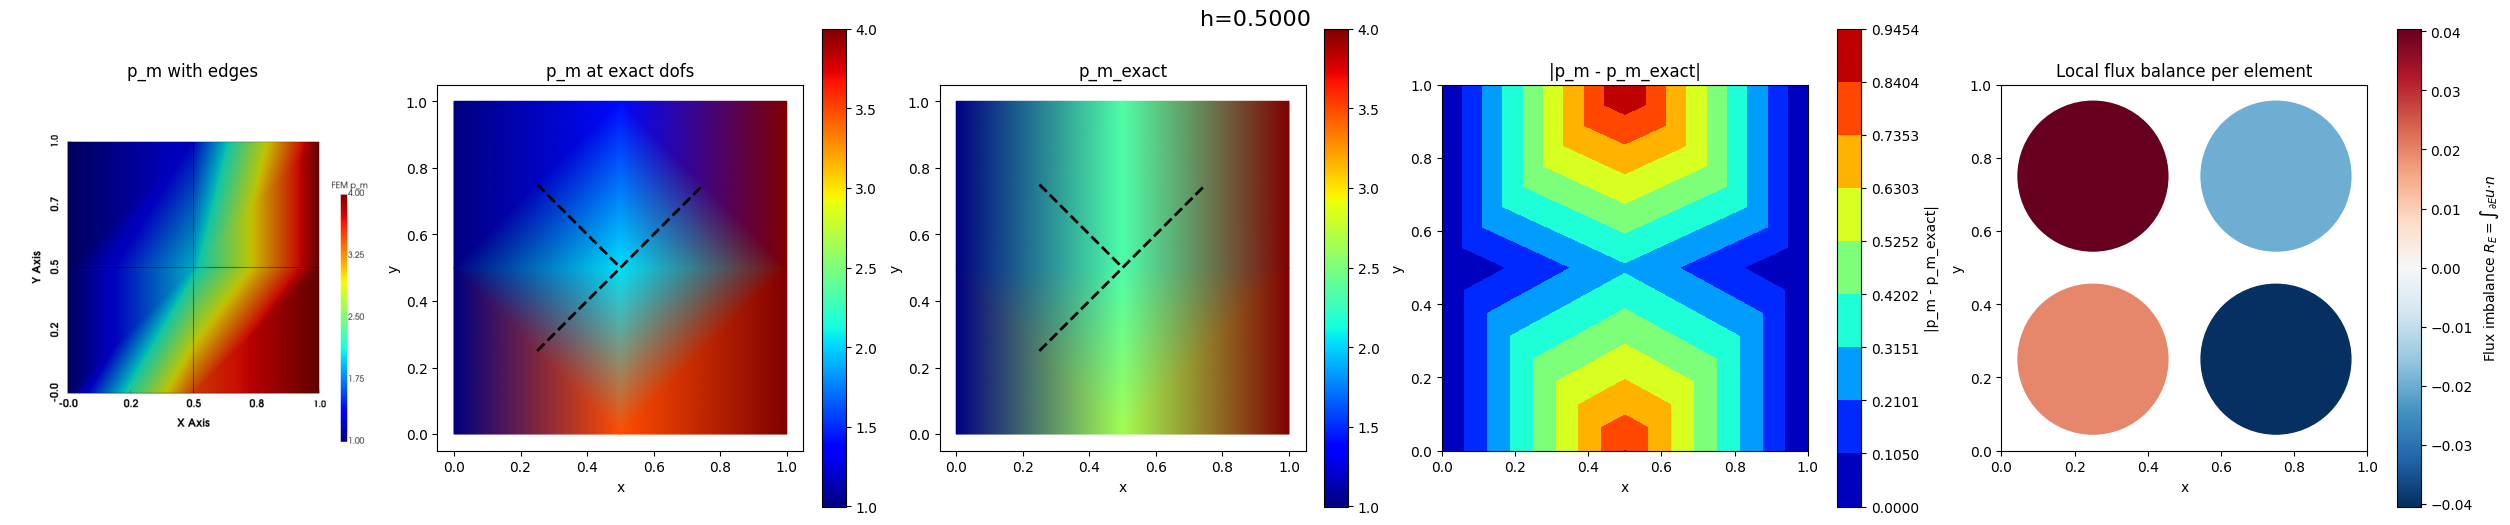

Info    : Reading 'Omega_ex1_1.msh'...
Info    : 27 entities
Info    : 50 nodes
Info    : 16 elements
Info    : Done reading 'Omega_ex1_1.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000199598s, CPU 0.000424s)
Info    : 17 nodes 19 elements


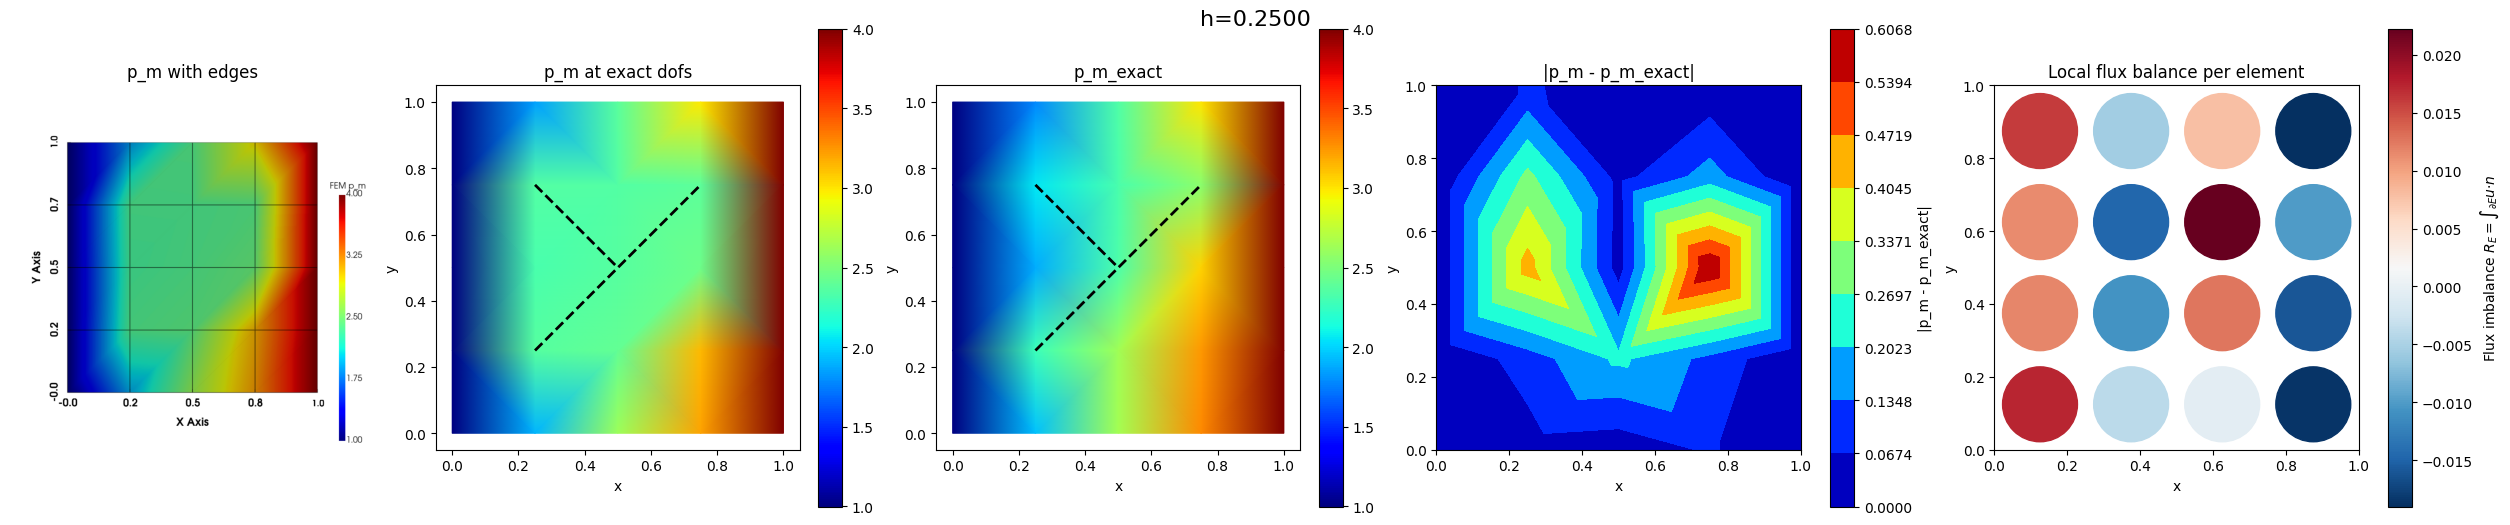

Info    : Reading 'Omega_ex1_2.msh'...
Info    : 27 entities
Info    : 162 nodes
Info    : 64 elements
Info    : Done reading 'Omega_ex1_2.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000238608s, CPU 0.000394s)
Info    : 17 nodes 19 elements


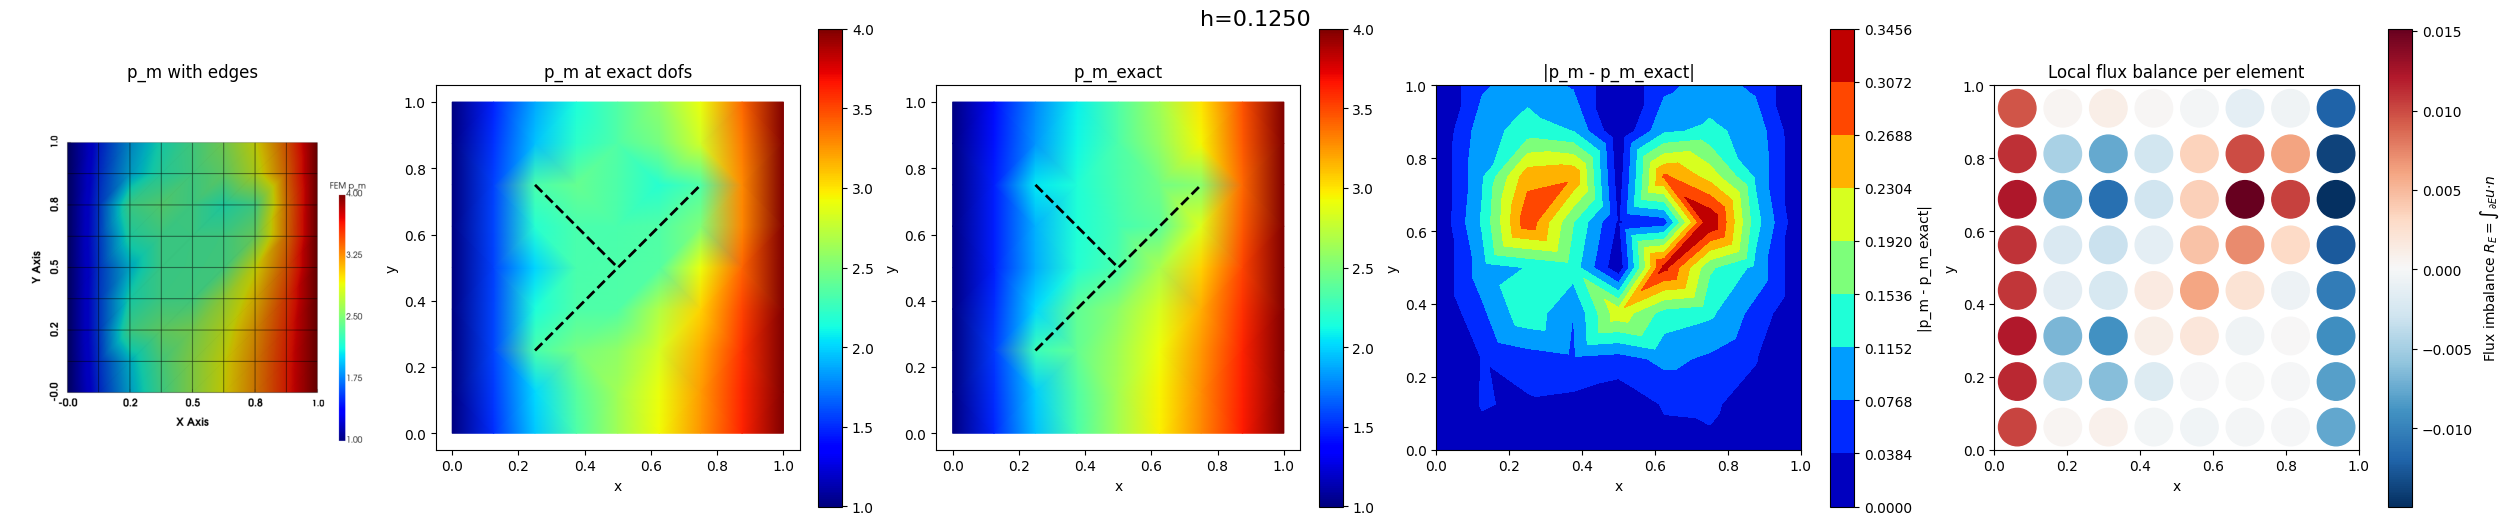

Info    : Reading 'Omega_ex1_3.msh'...
Info    : 27 entities
Info    : 578 nodes
Info    : 256 elements
Info    : Done reading 'Omega_ex1_3.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.0001959s, CPU 0.000242s)
Info    : 17 nodes 19 elements


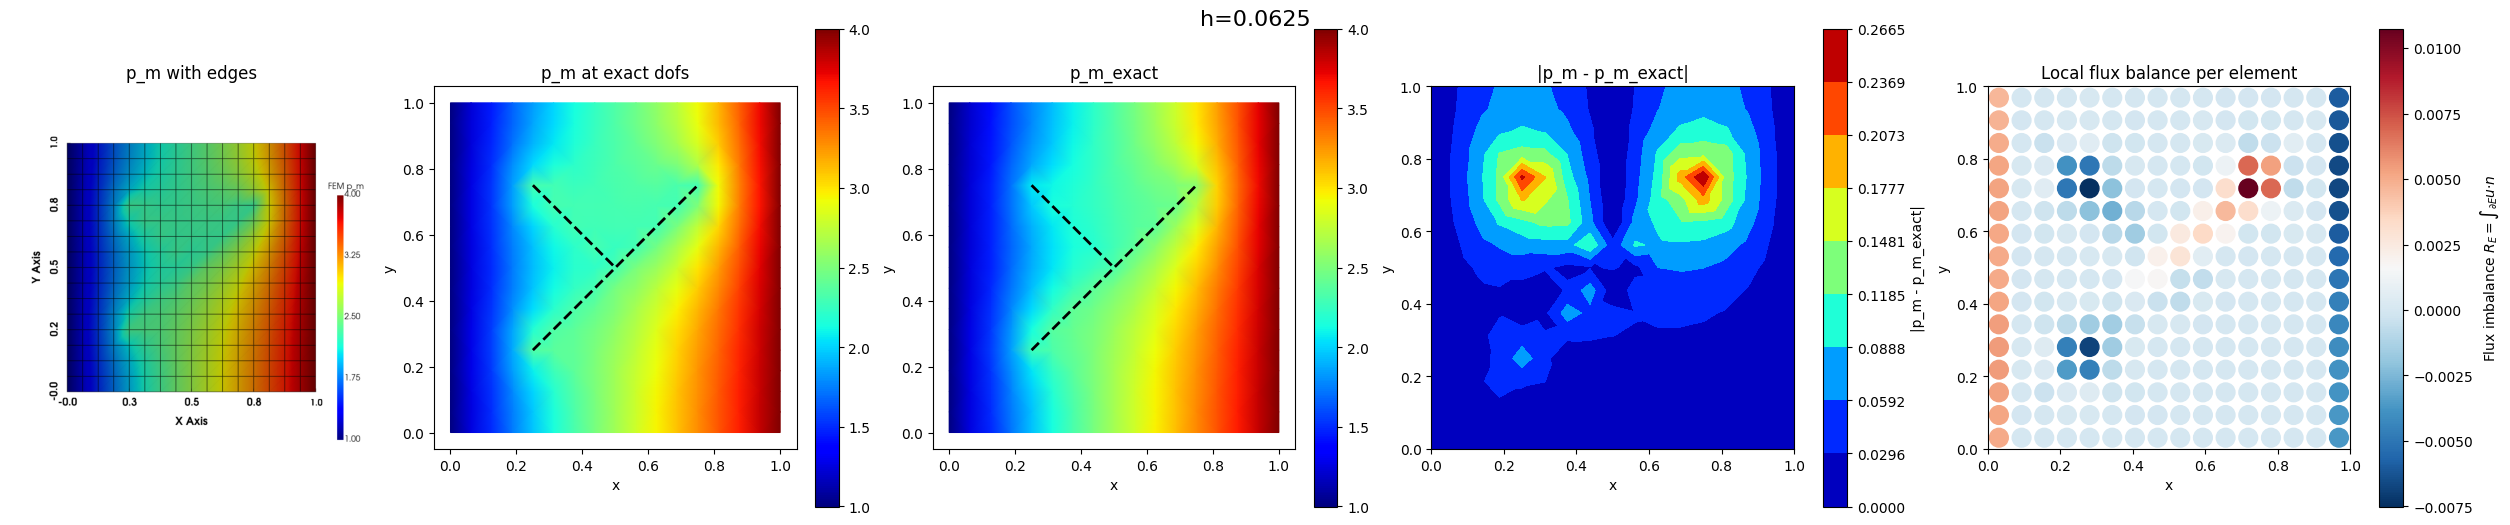

Info    : Reading 'Omega_ex1_4.msh'...
Info    : 27 entities
Info    : 2178 nodes
Info    : 1024 elements
Info    : Done reading 'Omega_ex1_4.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000165916s, CPU 0.000368s)
Info    : 17 nodes 19 elements


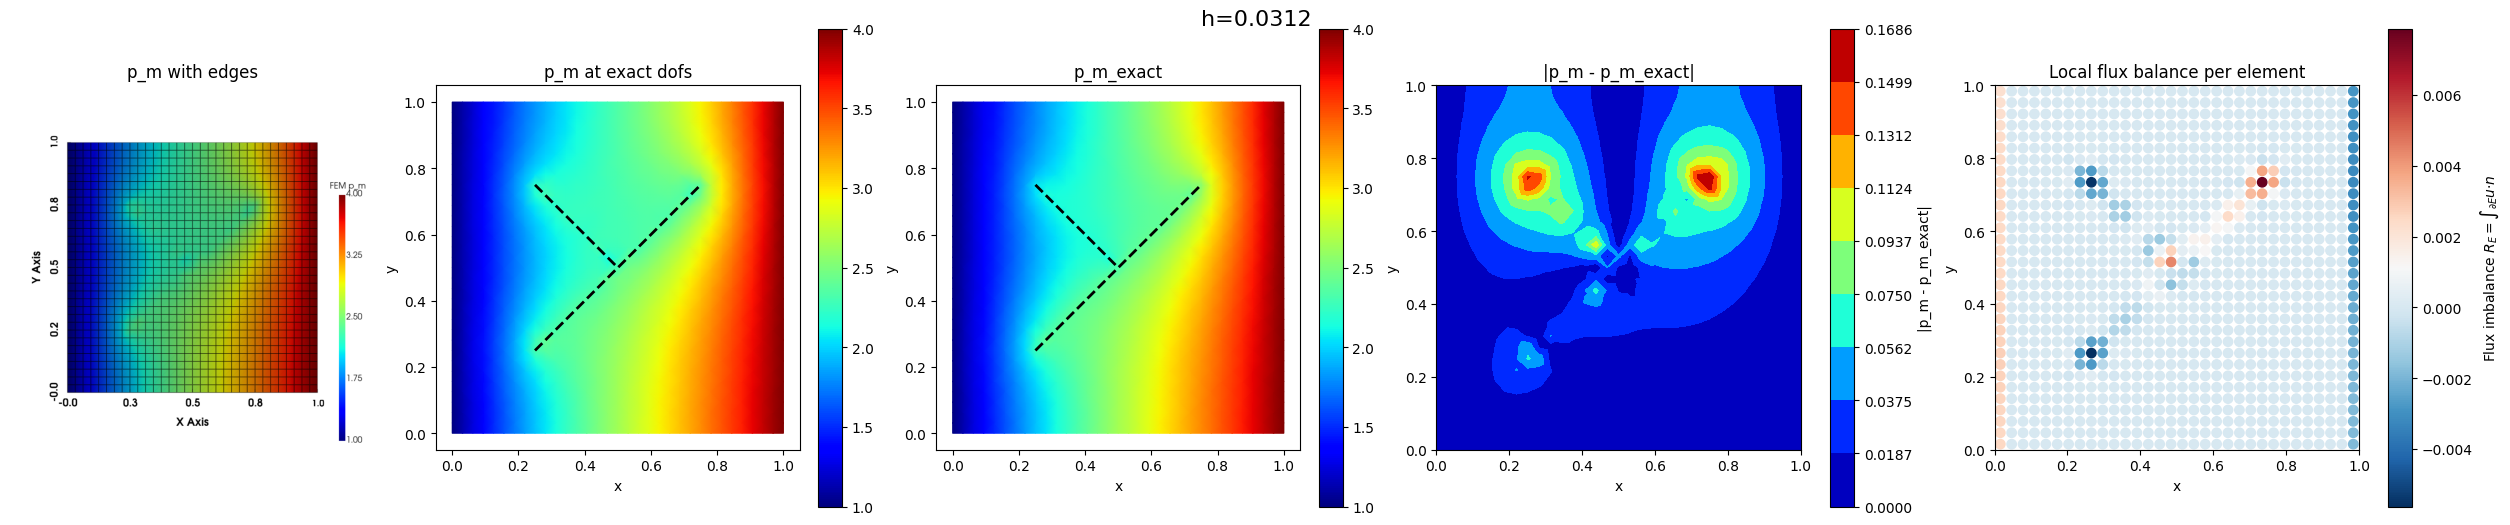

Info    : Reading 'Omega_ex1_5.msh'...
Info    : 27 entities
Info    : 8450 nodes
Info    : 4096 elements
Info    : Done reading 'Omega_ex1_5.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.0010327s, CPU 0.001491s)
Info    : 17 nodes 19 elements


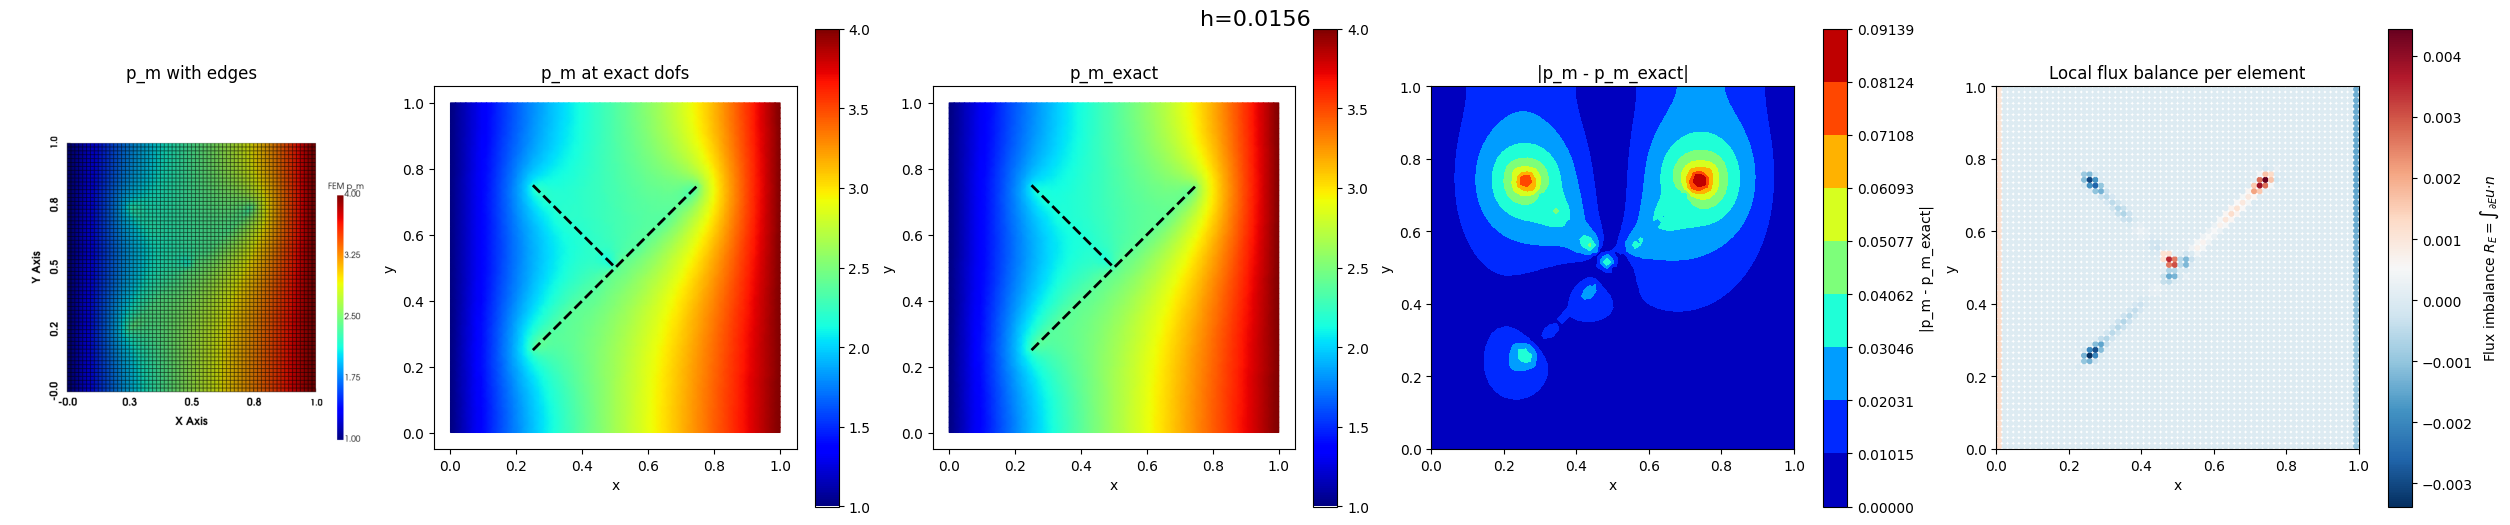

Info    : Reading 'Omega_ex1_6.msh'...
Info    : 27 entities
Info    : 33282 nodes
Info    : 16384 elements
Info    : Done reading 'Omega_ex1_6.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000160585s, CPU 0.000173s)
Info    : 17 nodes 19 elements


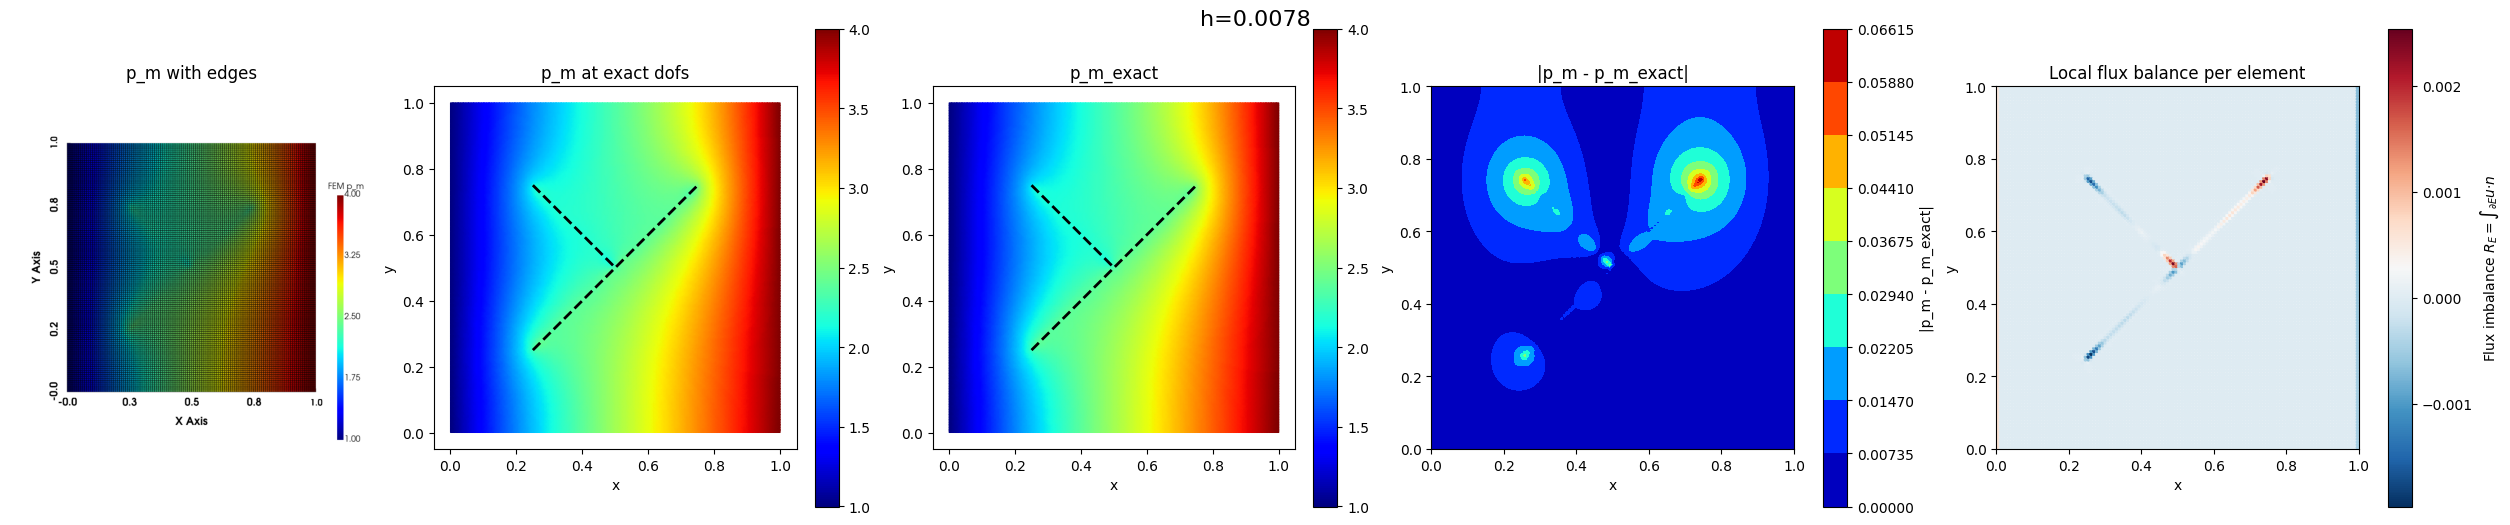

Info    : Reading 'Omega_ex1_7.msh'...
Info    : 27 entities
Info    : 132098 nodes
Info    : 65536 elements                                                                                      
Info    : Done reading 'Omega_ex1_7.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000381694s, CPU 0.00079s)
Info    : 17 nodes 19 elements


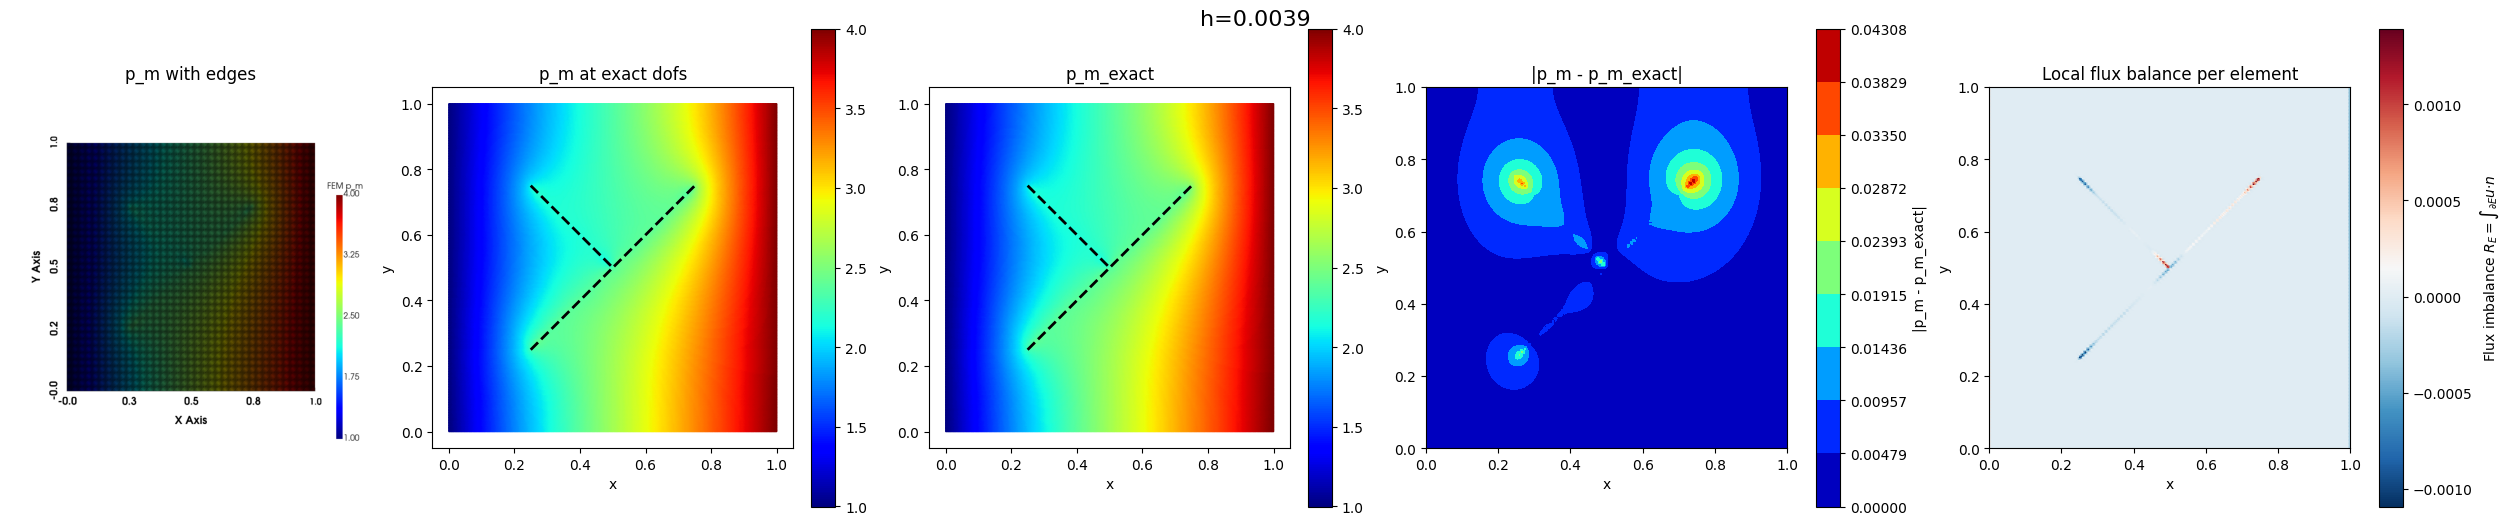

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


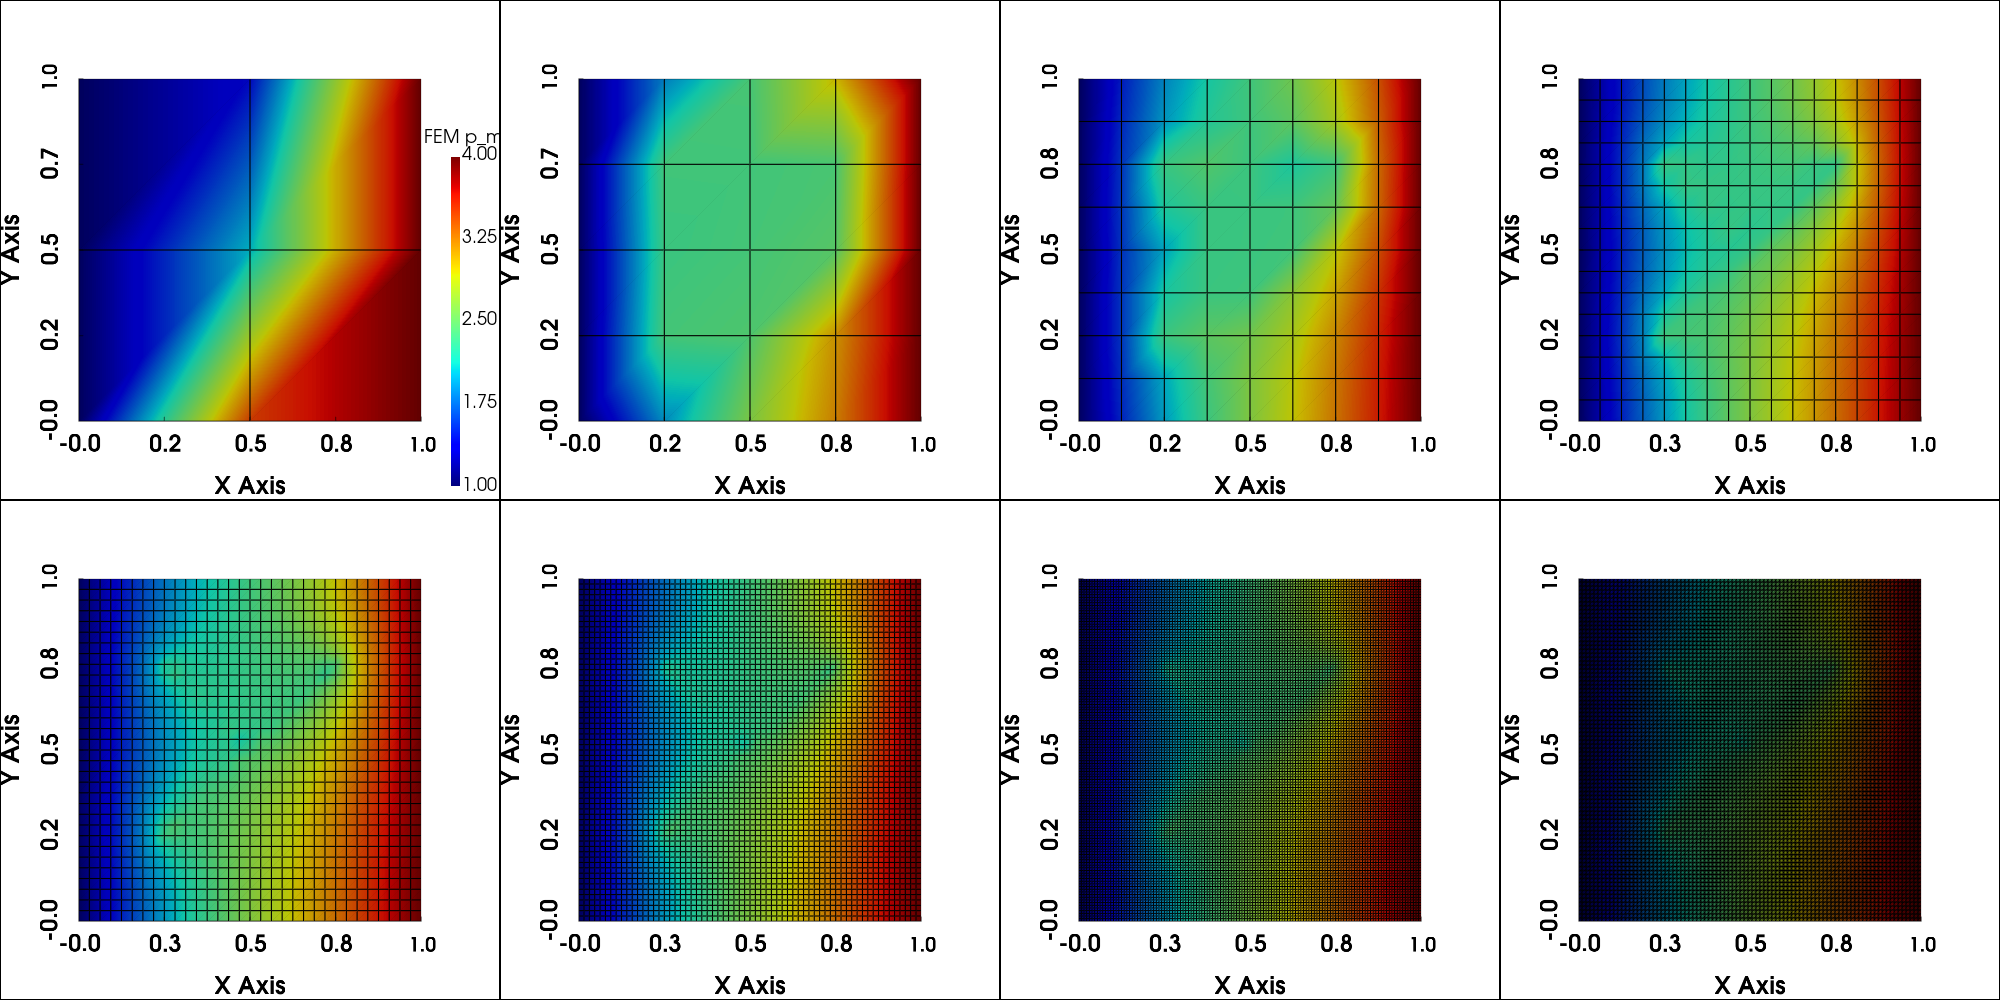

In [4]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # Build a search tree on the fine mesh
    bbt_fine = geometry.bb_tree(mesh_fine, mesh_fine.topology.dim)

    mid_tree_fine = geometry.create_midpoint_tree(
        mesh_fine, tdim,
        np.arange(mesh_fine.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # Allocate target on the coarse space
    # Build search trees on the COARSE mesh (we evaluate p there)
    # --- Search structures on the FINE mesh (where p_exact lives) ---
    bbt_fine = geometry.bb_tree(mesh_fine, tdim)
    mid_tree_fine = geometry.create_midpoint_tree(
        mesh_fine, tdim,
        np.arange(mesh_fine.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the COARSE space (values of p_exact sampled at coarse DoF points) ---
    p_exact_on_coarse = fem.Function(p.function_space)

    def eval_p_exact_on_points(x: np.ndarray) -> np.ndarray:
        """Return p_exact (defined on FINE mesh) evaluated at points x on the COARSE mesh."""
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on FINE mesh
        cands = geometry.compute_collisions_points(bbt_fine, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_fine, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest fine cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_fine, mid_tree_fine, mesh_fine, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate p_exact at those points/cells
        vals_1d = p_exact.eval(X3, cells)                  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)
        # For vector-valued fields of size m: return np.asarray(vals_1d).T  # (m, N)

    # IMPORTANT: pass the callable itself
    p_exact_on_coarse.interpolate(eval_p_exact_on_points)

    # --- Integrate on the COARSE mesh/domain ---
    dx = ufl.dx(domain=mesh_coarse)
    err = p - p_exact_on_coarse

    # ||err||_L2^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_exact_on_coarse, p_exact_on_coarse) * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_exact_on_coarse), ufl.grad(p_exact_on_coarse)) * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,   # <-- often what people plot as “H1 error”
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

for ref in range(N_ref):
    filename = f"Omega_ex1_{ref}.msh"
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
    tdim = Omega.topology.dim  # 2
    # fdim = 1             # 1
    # Compute cell diameters (length of the longest edge in each cell)
    # all_h = compute_cell_sizes(Omega, "max")

    # For example, get average or min/max
    # h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

    coords = Omega.geometry.x
    hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
    hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
    h = min(hx, hy)
    # Clear gmsh model before building Γ
    # gmsh.clear()

    # ================= Γ: line (1D embedded in 3D plane z=0) =================
    gmsh.initialize()
    gmsh.model.add("Gamma")
    h_g = h / 2

    lines = []
    for xs, ys, xe, ye in zip(x_start, y_start, x_end, y_end):
        p0 = gmsh.model.occ.addPoint(xs, ys, 0.01)
        p1 = gmsh.model.occ.addPoint(xe, ye, 0.01)
        lid = gmsh.model.occ.addLine(p0, p1)
        lines.append(lid)
        gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)

    gmsh.model.occ.synchronize()

    pg_gamma = gmsh.model.addPhysicalGroup(1, lines)
    gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
    gmsh.model.mesh.generate(1)

    Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(
        gmsh.model, comm, rank, gdim=3)[0:3]

    gmsh.finalize()

    order = 1
    V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
    V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
    V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
    W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

    # ---------------------------------------------------------------------
    # 3. Trial and Test functions
    # ---------------------------------------------------------------------
    phi, psi, mu = ufl.TestFunctions(W)
    p_m, p_f, lmbd = ufl.TrialFunctions(W)

    # ---------------------------------------------------------------------
    # 4. Spatial coordinates and given data
    # ---------------------------------------------------------------------
    x = ufl.SpatialCoordinate(Omega)
    f_m = fem.Constant(Omega, 0.0)
    f_f = fem.Constant(Gamma, 0.0)

    # k_m = fem.Constant(Omega, 1.0)
    # Diagonal entries
    k_values = np.array([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0]])

    # Define as a constant tensor field over Omega
    k_m = fem.Constant(Omega, k_values)
    k_f = fem.Constant(Gamma, 1.0)

    dx = ufl.Measure("dx", domain=Omega)
    ds = ufl.Measure("dx", domain=Gamma)

    # ---------------------------------------------------------------------
    # 5. Weak formulations
    # ---------------------------------------------------------------------
    # --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
    from fenicsx_ii import Average, Circle
    import basix.ufl
    R = np.min([0.01, h/4])         # tube/circle radius around Γ (tune as you like)
    q_degree = 16   # quadrature degree along the circle (tune)

    # Restriction operators for trial and test sides
    restriction_trial = Circle(Gamma, R, degree=q_degree)
    restriction_test  = Circle(Gamma, R, degree=q_degree)

    # Quadrature space on Γ used to represent the averages
    q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
    Rs   = fem.functionspace(Gamma, q_el)

    # Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
    avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
    avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

    # --- Bulk domain Ω ---------------------------------------------------
    a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
    # a_m1 = -lmbd * phi * ds
    a_m1 = - lmbd * avg_phi * ds
    a_m = a_m0 + a_m1
    L_m = f_m * phi * dx

    # --- Interface Γ -----------------------------------------------------
    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f = a_f0 + a_f1
    L_f = f_f * psi * ds

    # --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
    # a_l0 = p_m * mu * ds
    a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
    a_l1 = -p_f * mu * ds
    a_l = a_l0 + a_l1
    L_l = fem.Constant(Gamma, 0.0) * mu * ds

    # ---------------------------------------------------------------------
    # 6. Combine interface weak form
    # ---------------------------------------------------------------------
    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    F = a_m - L_m + a_gamma - L_gamma
    residual = ufl.extract_blocks(F)

    # Compute bounding box to locate sides
    coords = Omega.geometry.x
    x = coords[:, 0]
    y = coords[:, 1]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Tolerance for side detection
    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # Locate dofs on each side
    left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
    right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
    bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
    top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

    # Union of all boundary dofs for which we enforce a value
    # all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
    all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

    # Build a Function-valued BC so we can assign side-dependent values
    p_m_bc = fem.Function(V_m)
    # p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
    p_m_bc.x.array[left_dofs] = 1.0
    p_m_bc.x.array[right_dofs]  = 4.0

    # One BC object over the union of dofs with piecewise values
    bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

    # tolerance scaled to Γ
    tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

    # locate dofs at each tip
    # tip1_dofs = fem.locate_dofs_geometrical(
    #     V_f,
    #     lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
    #                             np.isclose(x[1], y_start, atol=tol_g))
    # )
    # tip2_dofs = fem.locate_dofs_geometrical(
    #     V_f,
    #     lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
    #                             np.isclose(x[1], y_end, atol=tol_g))
    # )
    # # OR (ii) Different values at the two tips -> two BC objects
    # both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    # # one Function-valued BC with piecewise values
    # pf_fun = fem.Function(V_f)
    # # pf_fun.x.array[:] = 0.0
    # pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
    # pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

    # bc_pf = fem.dirichletbc(pf_fun)

    # add it
    bcs = [bc_pm]

    a = a_m + a_gamma
    L = L_m + L_gamma

    from fenicsx_ii import LinearProblem, assemble_scalar
    petsc_options = {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    }
    problem = LinearProblem(
        a,
        L,
        petsc_options_prefix="coupled_poisson",
        petsc_options=petsc_options,
        bcs=bcs,
    )
    p_m, p_f, lmbd = problem.solve()
    p_m.name = "p_m"
    p_f.name = "p_f"
    lmbd.name = "lmbd"

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    thickness = 0.02          # same value you extruded with
    z_mid = 0 / 2.0   # center of the slab
    # 0) coords from the COARSE space (assumes Lagrange/nodal basis)
    V_coarse = p_m.function_space
    X_coarse = V_coarse.tabulate_dof_coordinates()  # shape (Ndof_c, gdim)
    Ndof_c, gdim = X_coarse.shape

    # make 3D point array for eval (pad z if problem is 2D)
    if gdim == 2:
        X3 = np.column_stack([X_coarse, np.zeros(Ndof_c)])
    else:
        X3 = X_coarse

    # 1) find containing cells for these coarse points on the (finer) mesh of p_m_exact
    mesh_f = p_m_exact.function_space.mesh
    tdim_f = mesh_f.topology.dim

    bbt = geometry.bb_tree(mesh_f, tdim_f)
    cands = geometry.compute_collisions_points(bbt, X3)
    hits = geometry.compute_colliding_cells(mesh_f, cands, X3)

    cells = np.full(Ndof_c, -1, dtype=np.int32)
    for i in range(Ndof_c):
        li = hits.links(i)
        if len(li) > 0:
            cells[i] = li[0]

    # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    missing = np.where(cells == -1)[0]
    if missing.size:
        mid_tree = geometry.create_midpoint_tree(
            mesh_f, tdim_f,
            np.arange(mesh_f.topology.index_map(tdim_f).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt, mid_tree, mesh_f, X3[missing])
        cells[missing] = nearest

    # 2) evaluate p_m_exact at those COARSE-space coordinates
    p_exact_on_coarsepts = p_m_exact.eval(X3, cells).ravel()

    # 3) grab the "coarse" values at *their own* dofs
    # (for standard Lagrange/nodal spaces, the coefficient equals the nodal value)
    p_coarse_vals = p_m.x.array.copy().ravel()

    # 4) build plotting arrays (no error norms here)
    x = X_coarse[:, 0].ravel()
    y = X_coarse[:, 1].ravel()
    diff_abs = np.abs(p_coarse_vals - p_exact_on_coarsepts)

    # triangulation in the (x, y) plane
    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    
    tri = mtri.Triangulation(x, y)

    # common color range taken from both fields
    vmin = float(min(np.nanmin(p_exact_on_coarsepts), np.nanmin(p_exact_on_coarsepts)))
    vmax = float(max(np.nanmax(p_exact_on_coarsepts), np.nanmax(p_exact_on_coarsepts)))

    # --- PyVista rendering of p_m on its mesh (as you had) ---
    topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
    grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
    grid_2d.point_data["p_m"] = p_m.x.array.real

    plotter0 = pv.Plotter(off_screen=True, window_size=(800, 800))
    plotter0.add_mesh(
        grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
        clim=[vmin, vmax],  # or [1,4] if you want fixed scale
        scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
    )
    plotter0.show_bounds()
    plotter0.view_xy()
    img = plotter0.screenshot(return_img=True)
    plotter0.close()

    # optional: a segment to overlay (keep your existing endpoints)
    # x_start, x_end, y_start, y_end must exist if you want the line shown
    have_line = all(name in globals() for name in ["x_start","x_end","y_start","y_end"])

    fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
    fig.suptitle(f"h={h:.4f}", fontsize=16, y=1.02)  # keep your h variable

    # Panel 0: PyVista rendering
    axes[0].imshow(img)
    axes[0].set_title("p_m with edges")
    axes[0].axis("off")

    # Panel 1: p_m sampled at exact dofs
    im0 = axes[1].tripcolor(tri, p_coarse_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[1].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[1].set_title('p_m at exact dofs')
    axes[1].set_aspect('equal')
    fig.colorbar(im0, ax=axes[1])

    # Panel 2: p_m_exact values at its dofs
    im1 = axes[2].tripcolor(tri, p_exact_on_coarsepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[2].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[2].set_title('p_m_exact')
    axes[2].set_aspect('equal')
    fig.colorbar(im1, ax=axes[2])

    # Panel 3: absolute difference contours
    levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    cont = axes[3].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    axes[3].set_title('|p_m - p_m_exact|')
    axes[3].set_aspect('equal')
    fig.colorbar(cont, ax=axes[3], label='|p_m - p_m_exact|')

    n = ufl.FacetNormal(Omega)
    u = -k_m * ufl.grad(p_m)

    # create DG0 space to store results
    W = fem.functionspace(Omega, ("DG", 0))
    w = ufl.TestFunction(W)

    # assemble elementwise flux residuals (split equally across neighbors)
    R_form = ufl.jump(u, n)*ufl.avg(w)*ufl.dS + ufl.dot(u, n)*w*ufl.ds
    R_vec = fem.petsc.assemble_vector(fem.form(R_form))

    R = fem.Function(W)
    R.x.array[:] = R_vec.array
    R.x.scatter_forward()

    # Compute cell centroids
    mesh = Omega
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim, 0)
    cell_to_vertices = mesh.topology.connectivity(tdim, 0)
    x = mesh.geometry.x

    centroids = np.array([
        x[cell_to_vertices.links(c)].mean(axis=0)
        for c in range(mesh.topology.index_map(tdim).size_local)
    ])

    # Get local residual values (per cell)
    R_local = R.x.array

    dx_points = axes[4].transData.transform((1,0))[0] - axes[4].transData.transform((0,0))[0]
    dy_points = axes[4].transData.transform((0,1))[1] - axes[4].transData.transform((0,0))[1]
    r_points = h/2 * 0.6 * (dx_points + dy_points)   # average for roughly equal scaling

    # Marker size in points²
    s_val = r_points**2

    sc = axes[4].scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    axes[4].set_aspect('equal')
    fig.colorbar(sc, ax=axes[4], label="Flux imbalance $R_E = ∫_{∂E} u·n$")
    # plt.colorbar(sc, )
    axes[4].set_title("Local flux balance per element")
    axes[4].set_xlim(0, 1)
    axes[4].set_ylim(0, 1)
    
    # plt.axis("equal")
    # plt.xlabel("x"); plt.ylabel("y")
    # plt.title("Local flux balance per element")

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.show()
    
    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

    if ref < 8:
        # Panel 1: MRST (cells)
        ip = int(ref/4)
        jp = ref % 4
        plotter.subplot(ip, jp)
        plotter.add_mesh(
            grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
            clim=[1, 4],
            scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
        )
        plotter.show_bounds(); plotter.view_xy()
        plotter.link_views()
plotter.show()
    

In [21]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list, h_list)
    roc_H1s  = _roc(H1s_list, h_list)
    roc_rH1s = _roc(rH1s_list, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    0.5000     0.044843         —     0.217112            —
    0.2500     0.022887     0.970     0.184650        0.234
    0.1250     0.015722     0.542     0.139444        0.405
    0.0625     0.008714     0.851     0.083211        0.745
    0.0312     0.005095     0.774     0.058854        0.500
    0.0156     0.002470     1.045     0.030580        0.945
    0.0078     0.001385     0.834     0.019653        0.638
    0.0039     0.000859     0.689     0.013900        0.500
----------------------------------------------------------------


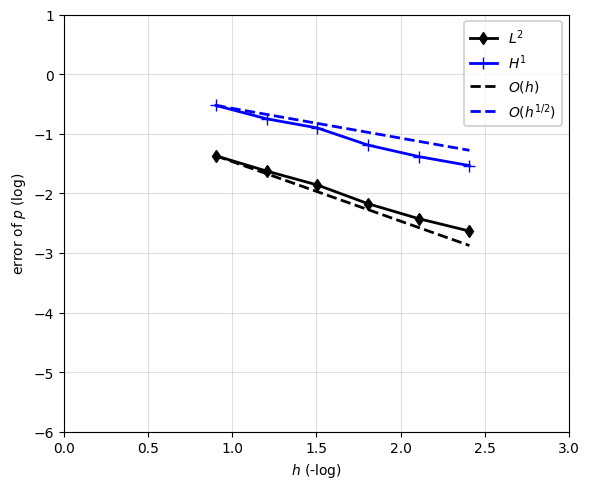

In [24]:
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list[-6:], dtype=float)
H1_err = np.array(rH1s_list[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.0
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h)$")

k_ref = 0.5
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h^{1/2})$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"error of $p$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-6,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


In [25]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list_pf,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list_pf, h_list)
    roc_H1s  = _roc(H1s_list_pf, h_list)
    roc_rH1s = _roc(rH1s_list_pf, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list_pf[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list_pf[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    0.5000     0.416522         —     1.749528            —
    0.2500     0.103816     2.004     0.819365        1.094
    0.1250     0.099824     0.057     0.836110       -0.029
    0.0625     0.085877     0.217     0.851426       -0.026
    0.0312     0.055353     0.634     0.852812       -0.002
    0.0156     0.036592     0.597     0.854360       -0.003
    0.0078     0.033675     0.120     0.854921       -0.001
    0.0039     0.033563     0.005     0.855182       -0.000
----------------------------------------------------------------


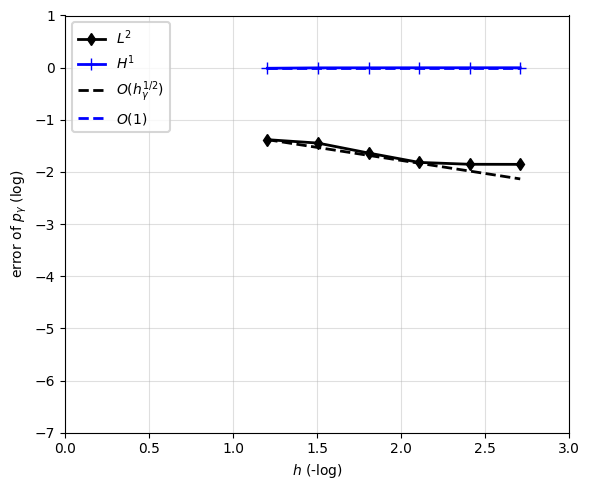

In [6]:
#p_f
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[-6:], dtype=float)
H1_err = np.array(rH1s_list_pf[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h/2)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 0.5
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h_\gamma^{1/2})$")

k_ref = 0.0
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(1)$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"error of $p_\gamma$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-7,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


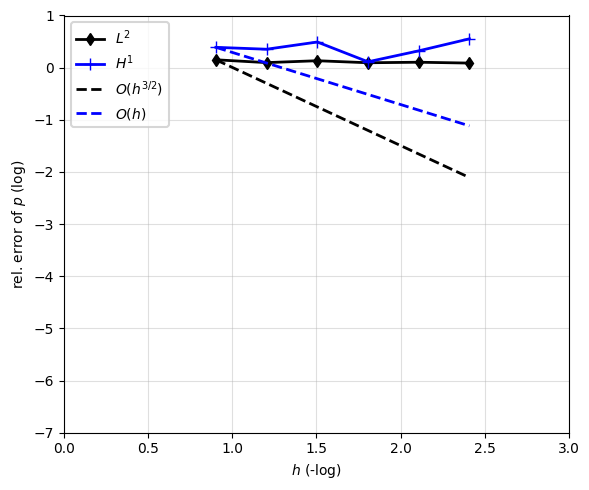

In [7]:
#lmbd
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-6:], dtype=float)
L2_err = np.array(rL2s_fem_list_lmbd[-6:], dtype=float)
H1_err = np.array(rH1s_list_lmbd[-6:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.5
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h^{3/2})$")

k_ref = 1.0
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h)$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"rel. error of $p$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-7,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


In [26]:
from dolfinx import fem
import ufl

n = ufl.FacetNormal(Omega)
u = -k_m * ufl.grad(p_m)

# create DG0 space to store results
W = fem.functionspace(Omega, ("DG", 0))
w = ufl.TestFunction(W)

# assemble elementwise flux residuals (split equally across neighbors)
R_form = ufl.jump(u, n)*ufl.avg(w)*ufl.dS + ufl.dot(u, n)*w*ufl.ds
R_vec = fem.petsc.assemble_vector(fem.form(R_form))

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

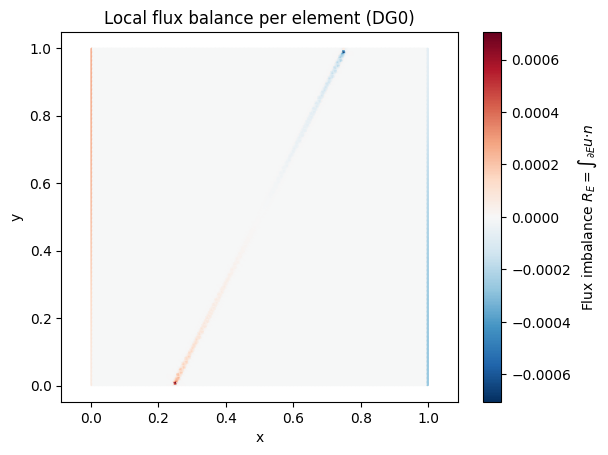

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Compute cell centroids
mesh = Omega
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, 0)
cell_to_vertices = mesh.topology.connectivity(tdim, 0)
x = mesh.geometry.x

centroids = np.array([
    x[cell_to_vertices.links(c)].mean(axis=0)
    for c in range(mesh.topology.index_map(tdim).size_local)
])

# Get local residual values (per cell)
R_local = R.x.array

plt.figure()
sc = plt.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
plt.colorbar(sc, label="Flux imbalance $R_E = ∫_{∂E} u·n$")
plt.axis("equal")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Local flux balance per element (DG0)")
plt.show()
